**Multivariate Time Series Forecasting using Python**

Multivariate Time Series Forecasting is preferable when the variables may have dependencies or interactions with one another. The goal is to capture these interdependencies to make accurate predictions for each variable over a future time period. Below is the process we can follow for the task of Multivariate Time Series Forecasting:

Determine which variables are relevant to the forecast. Besides the target variable you want to predict, identify other variables that might influence it.
Collect historical data for all variables identified. This data should cover a sufficient time period to capture seasonal patterns, trends, and any cyclical behaviour.
Handle missing values, outliers, and anomalies in the data. It might involve imputation, data smoothing, or anomaly detection techniques.
Use plots and charts to understand relationships between variables, identify trends, and detect seasonality or cyclic patterns.
Select and use forecasting models suitable for multivariate time series data. Options include Vector Auto Regression (VAR), State Space Models (like Kalman Filters), and machine learning approaches such as LSTM (Long Short-Term Memory) networks.

In [1]:
import pandas as pd

stocks_data = pd.read_csv("/content/drive/MyDrive/stocks.csv")

print(stocks_data.head())

  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  


The dataset consists of the following columns:

Ticker: The stock symbol.

Date: The date of the trading session.

Open: The opening price of the stock for the trading session.

High: The highest price of the stock during the trading session.

Low: The lowest price of the stock during the trading session.

Close: The closing price of the stock for the trading session.

Adj Close: The adjusted closing price of the stock (adjusted for things like dividends and stock splits).

Volume: The number of shares traded during the trading session.

Next, I will perform the following tasks for Data Preparation:

- Check for missing values in the dataset.
- Convert the Date column to a datetime type for time series analysis.
- Check how many unique stocks (Tickers) are present and their respective data points.
- Resample the data to a consistent time frequency if necessary (e.g., daily, weekly), based on the data’s current granularity and the forecasting goals.

Let’s proceed with these steps:

In [2]:
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])

missing_values = stocks_data.isnull().sum()

unique_stocks = stocks_data['Ticker'].value_counts()

print(missing_values)

Ticker       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [3]:
print(unique_stocks)

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64


There are no missing values in the dataset, which is great. The dataset contains data for four unique stocks: Apple (AAPL), Microsoft (MSFT), Netflix (NFLX), and Google (GOOG), each with 62 data points.



Now, to explore the dataset, let’s:

Check the time range of the dataset.
Visualize the closing price trends for each stock.
It will give us a better understanding of the dataset’s characteristics, such as trends and seasonality. Let’s start by checking the time range:

In [4]:
time_range = stocks_data['Date'].min(), stocks_data['Date'].max()
print(time_range)

(Timestamp('2023-02-07 00:00:00'), Timestamp('2023-05-05 00:00:00'))


The dataset covers the time range from February 7, 2023, to May 5, 2023, which is approximately 3 months. Given this relatively short time frame, we’ll focus on visualizing the closing price trends to understand the data better. Now, let’s plot the closing price trends for each of the four stocks:

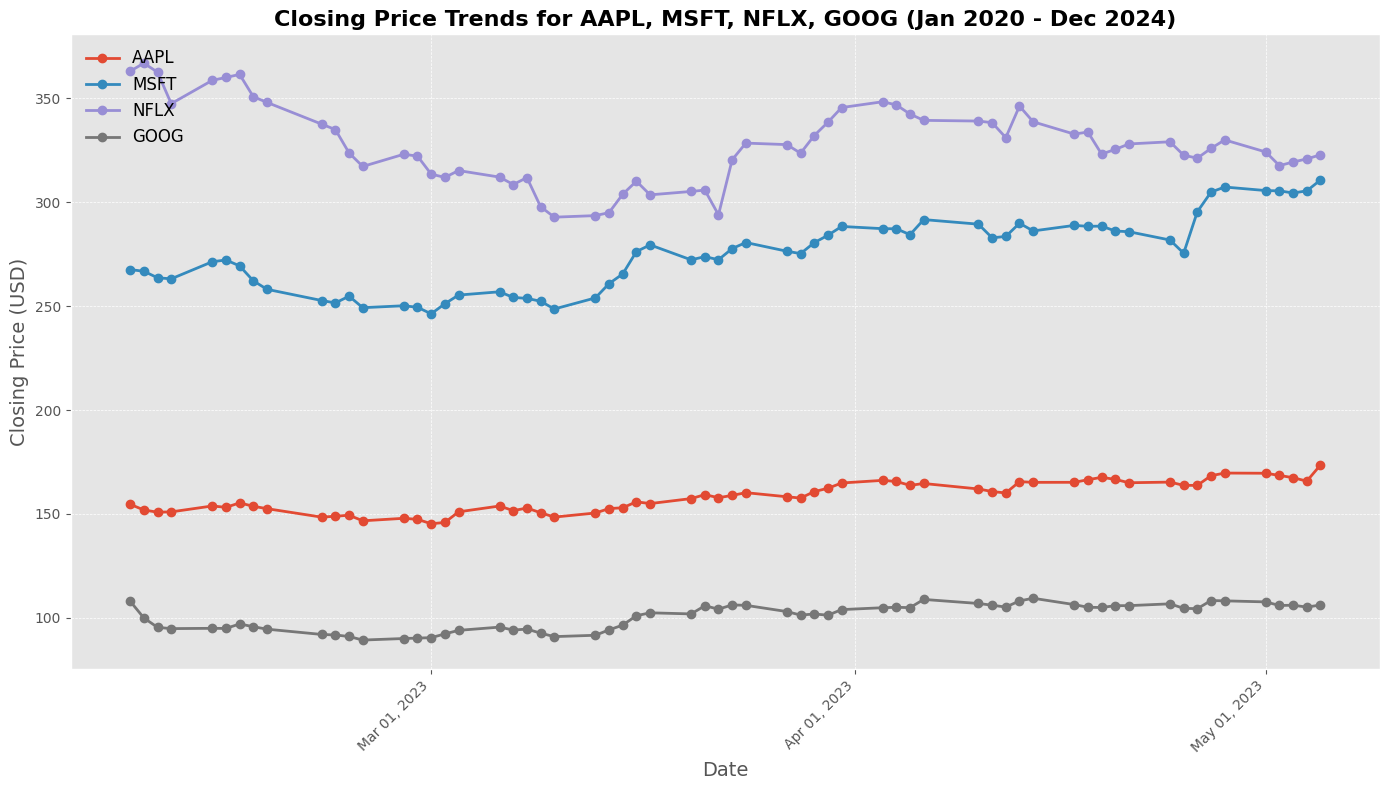

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('ggplot')  # Use ggplot style for a clean and grid-based look

fig, ax = plt.subplots(figsize=(14, 8))

# Loop over each unique stock ticker to plot the data
for ticker in unique_stocks.index:
    subset = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(subset['Date'], subset['Close'], label=ticker, linewidth=2, marker='o', markersize=6)

# Title and axis labels with enhanced information
ax.set_title('Closing Price Trends for AAPL, MSFT, NFLX, GOOG (Jan 2020 - Dec 2024)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Closing Price (USD)', fontsize=14)

# Use a date formatter for the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend with improved positioning
ax.legend(loc='upper left', fontsize=12, frameon=False)

# Enable gridlines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()


The above plot shows the closing price trends for Apple (AAPL), Microsoft (MSFT), Netflix (NFLX), and Google (GOOG) over the three months from February 2023 to May 2023. Each stock exhibits its pattern of fluctuations over this time.

**Model Selection and Data Preparation**

Moving on to model selection for forecasting, given the multivariate nature of our data, a Vector AutoRegression (VAR) model could be a suitable choice. VAR models can capture the linear interdependencies among multiple time series, which makes them a good fit for forecasting the prices of several stocks simultaneously.

Before we proceed with VAR modelling, it’s important to ensure that the time series data for each stock is stationary, as VAR models require stationarity. Stationarity means the statistical properties of the series (mean, variance) do not change over time. Let’s perform the following steps:

Use the Augmented Dickey-Fuller (ADF) test for each stock’s closing price.
Depending on the ADF test results, we may need to transform the data (e.g., by differencing) to achieve stationarity.
Train the VAR model and forecast the future values.
We’ll start with the ADF test for stationarity. Let’s do this for each stock’s closing price:

In [10]:
from statsmodels.tsa.stattools import adfuller

# function to perform Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'ADF Test on "{title}"')
    result = adfuller(series, autolag='AIC')  # ADF test
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('\n')

# perform ADF test on the 'Close' price of each stock
for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Close']
    adf_test(series, title=ticker)

ADF Test on "AAPL"
ADF Test Statistic             -0.291693
p-value                         0.926673
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "MSFT"
ADF Test Statistic             -0.149807
p-value                         0.944246
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "NFLX"
ADF Test Statistic             -2.150926
p-value                         0.224536
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745


ADF Test on "GOOG"
ADF Test Statistic             -1.431504
p-value         

The Augmented Dickey-Fuller (ADF) test results for each stock’s closing price indicate:

AAPL: The p-value is 0.927, suggesting we failed to reject the null hypothesis, and the series is non-stationary.
MSFT: With a p-value of 0.944, this series is also non-stationary.
NFLX: The p-value is 0.225, indicating non-stationarity.
GOOG: The p-value is 0.567, again indicating non-stationarity.
Since all series are non-stationary, we need to make them stationary before modelling. One common approach is to difference the series, which typically means to transform the data to represent the change from one period to the next rather than the absolute values.

Let’s make the series stationary by differencing the closing prices of each stock and then re-testing for stationarity:

In [11]:
# differencing the 'Close' price of each stock to make the series stationary
stocks_data['Diff_Close'] = stocks_data.groupby('Ticker')['Close'].transform(lambda x: x.diff())

for ticker in unique_stocks.index:
    series = stocks_data[stocks_data['Ticker'] == ticker]['Diff_Close'].dropna()
    adf_test(series, title=f"{ticker} - Differenced")

ADF Test on "AAPL - Differenced"
ADF Test Statistic             -5.238104
p-value                         0.000007
#Lags Used                      4.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137


ADF Test on "MSFT - Differenced"
ADF Test Statistic            -5.895024e+00
p-value                        2.864876e-07
#Lags Used                     1.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00


ADF Test on "NFLX - Differenced"
ADF Test Statistic            -8.022480e+00
p-value                        2.058613e-12
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.59319

After differencing the closing prices, the Augmented Dickey-Fuller (ADF) test results for each differenced series are:

AAPL – Differenced: The p-value is significantly less than 0.05, indicating that we can reject the null hypothesis. The series is stationary.
MSFT – Differenced: Similarly, the p-value is significantly low, confirming stationarity.
NFLX – Differenced: With a very low p-value, this series is also stationary.
GOOG – Differenced: This series is stationary as well, indicated by a very low p-value.
All differenced series are now stationary, which makes them suitable for VAR modelling for Multivariate Time Series Forecasting.

**Model Training**

Since we’re working with a relatively small dataset and a short time frame, we’ll proceed with training a VAR model on the entire dataset:



In [13]:
from statsmodels.tsa.vector_ar.var_model import VAR

# prepare the dataset for VAR model
var_data = stocks_data.pivot(index='Date', columns='Ticker', values='Diff_Close').dropna()

model = VAR(var_data)
model_fitted = model.fit(ic='aic')

forecast_steps = 5

forecasted_values = model_fitted.forecast(var_data.values[-model_fitted.k_ar:], steps=forecast_steps)

forecasted_df = pd.DataFrame(forecasted_values, index=pd.date_range(start=var_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=var_data.columns)

for column in forecasted_df.columns:
    forecasted_df[column] = (stocks_data.groupby('Ticker')['Close'].last()[column] + forecasted_df[column].cumsum())

print(forecasted_df)

Ticker            AAPL        GOOG        MSFT        NFLX
2023-05-06  174.369001  113.624024  320.179608  327.604320
2023-05-07  169.684437  104.915080  318.416783  342.704109
2023-05-08  168.190894  107.828473  329.210732  367.542312
2023-05-09  160.836027   99.287041  326.849012  348.088074
2023-05-10  167.645928  101.392914  317.986680  387.059442


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


The forecasted closing prices for each stock over the next 5 days have been successfully calculated. These forecasts reverse the differencing to present the expected closing prices in their original scale. To wrap up, we’ll visualize the historical closing prices along with the forecasted prices for each stock on a single graph. This visualization will help us understand the forecast in the context of recent trends:

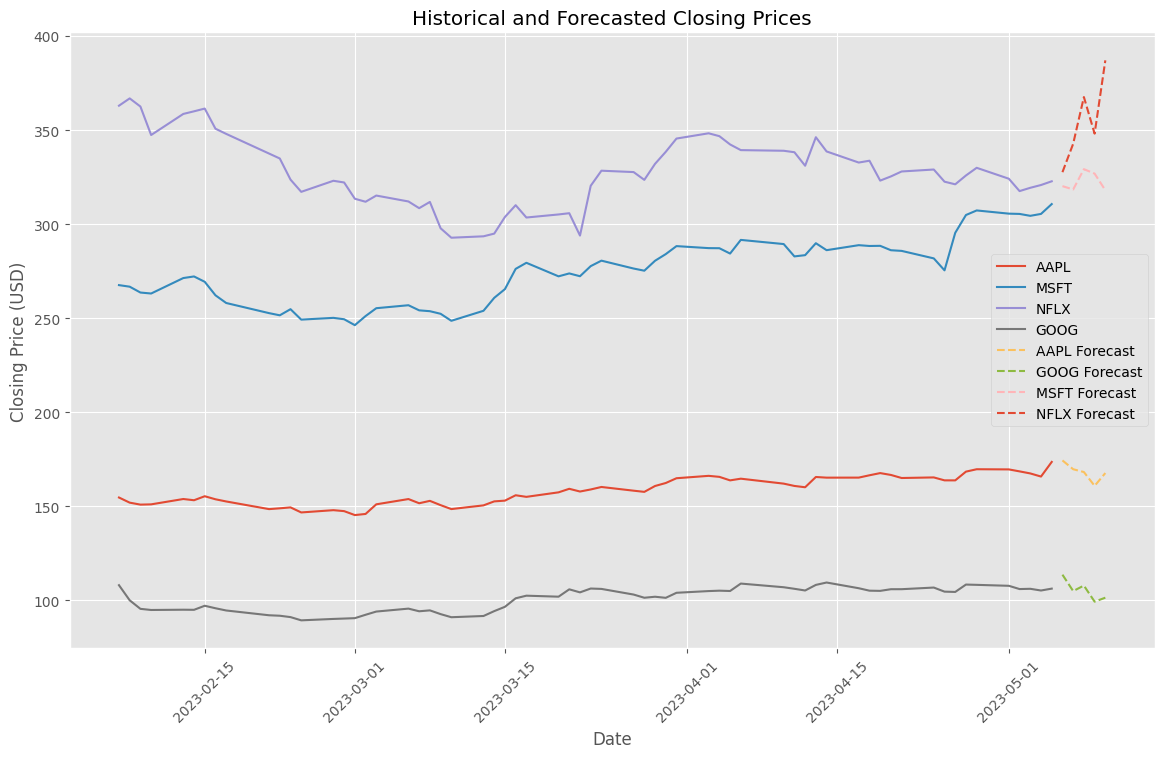

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))

# plot historical closing prices for each stock
for ticker in unique_stocks.index:
    historical_data = stocks_data[stocks_data['Ticker'] == ticker]
    ax.plot(historical_data['Date'], historical_data['Close'], label=ticker)

# plot the forecasted closing prices
for column in forecasted_df.columns:
    ax.plot(forecasted_df.index, forecasted_df[column], label=f'{column} Forecast', linestyle='--')

ax.set_title('Historical and Forecasted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price (USD)')
ax.legend()

plt.xticks(rotation=45)
plt.show()

**Summary**

So, this is how you can perform Multivariate Time Series Forecasting using Python. Multivariate Time Series Forecasting is preferable when the variables may have dependencies or interactions with one another. The goal is to capture these interdependencies to make accurate predictions for each variable over a future time period.